In [1]:
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.unet_multi_cond_bb import UNetModelWrapper as UNetModel
from torchdiffeq import odeint
from einops import rearrange

In [4]:
data = [] #, data_0_150[:, :1]
for i in [5, 40]:
    uvw_data = []
    for j in ["u"]:   
        uvw_data.append(np.load(f'/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_{j}_y{i}_all_out.npy'))
    data.append(uvw_data)
data = [np.concatenate(i, axis=1) for i in data]
data = np.stack(data, axis=1)

In [5]:
m_, std_ = data.mean(axis=(0,3,4), keepdims=True), data.std(axis=(0,3,4), keepdims=True)

In [15]:
X = (data[-1000:] - m_)/std_

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
ind = 0
wall_norm_dict = {0 : [5., 40.]}
batch_size=10
x_dim, y_dim = X.shape[-2:]
patch_size = 32
extra_x, extra_y = x_dim%patch_size ,y_dim%patch_size

In [23]:
def MSE(pred):
    return (((X)[:, 1] - pred)**2).mean()

In [24]:
exp=10
for iteration in (list(range(0,99,5)) + [99]):
    ot_cfm_model = UNetModel(dim=[1, 32, 32],
                            num_channels=128,
                            y_channels=2,
                            out_channels=1,
                            num_res_blocks=2,
                            num_head_channels=64,
                            attention_resolutions="64", #16, 8, 4
                            dropout=0.0,
                            use_new_attention_order=True,
                            use_scale_shift_norm=True)
    state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_pretrain/exps/vf_vf/y_corr/32_by_32_x_len/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
    ot_cfm_model.load_state_dict(state["model_state_dict"])
    ot_cfm_model.to(device)
    ot_cfm_model.eval();
    
    samples_list = []
    for batch in range(X.shape[0]//batch_size):
        with torch.no_grad():
            out = ot_cfm_model(torch.tensor((np.array(wall_norm_dict[ind])*np.ones((batch_size, 2))).astype(np.float32), device=device)
                            ,torch.tensor(X[batch*batch_size:(batch+1)*batch_size, ind], device=device)).detach().cpu().numpy()
        # out *= std_[:, ind+1]
        # out += m_[:, ind+1]
        samples_list.append(out)
        
    samples = np.concatenate(samples_list)
    print(f"{iteration} : {MSE(samples)}")

/tmp/ipykernel_2384187/4206549926.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_fl

0 : 0.6445002555847168
5 : 0.43461939692497253
10 : 0.3992762565612793
15 : 0.3904779255390167
20 : 0.37722352147102356
25 : 0.35438674688339233
30 : 0.3741532862186432
35 : 0.346652090549469
40 : 0.3448922634124756
45 : 0.3513876795768738
50 : 0.35080793499946594
55 : 0.34606173634529114
60 : 0.35890522599220276
65 : 0.3413413465023041
70 : 0.34768861532211304
75 : 0.34736427664756775
80 : 0.3579613268375397
85 : 0.3479000926017761
90 : 0.3448736071586609
95 : 0.35908275842666626
99 : 0.3551851511001587


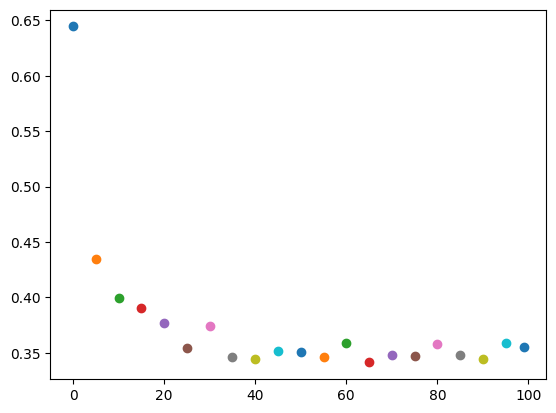

In [27]:
a = {0 : 0.6445002555847168,
5 : 0.43461939692497253,
10 : 0.3992762565612793,
15 : 0.3904779255390167,
20 : 0.37722352147102356,
25 : 0.35438674688339233,
30 : 0.3741532862186432,
35 : 0.346652090549469,
40 : 0.3448922634124756,
45 : 0.3513876795768738,
50 : 0.35080793499946594,
55 : 0.34606173634529114,
60 : 0.35890522599220276,
65 : 0.3413413465023041,
70 : 0.34768861532211304,
75 : 0.34736427664756775,
80 : 0.3579613268375397,
85 : 0.3479000926017761,
90 : 0.3448736071586609,
95 : 0.35908275842666626,
99 : 0.3551851511001587}

plt.figure()
for k, v in a.items():
    plt.scatter(k,v)